# Description
There are 3 parent folders containing data. These contain folders for individual patients and their data.
1. 20240201_UNEEG_ForMayo
    * patient folders contain multiple folders which contain .edf files
    * patient folders contain a .txt file with the seizure annotations.
2. 20250217_UNEEG_Extended
    * patient folders contain multiple folders which contain .edf files
    * most patient folders contain an annotations folder (with varying names) which contains a seizure annotations .txt file
    * P4Hk23M7L seems to contain a wrong recording time here: `V5i/U002-DE01-16_OUTPT_V5_000538_0004003_20000109_02_EEGdata.edf`. I can't find this file though, so maybe it's been resolved.
3. 20250501_SUBQ_SeizurePredictionCompetition_2025final/TrainingData
    * Contains a single folder for each patient with all their .edf files
    * Contains an Excel sheet with a sheet per patient with their seizures

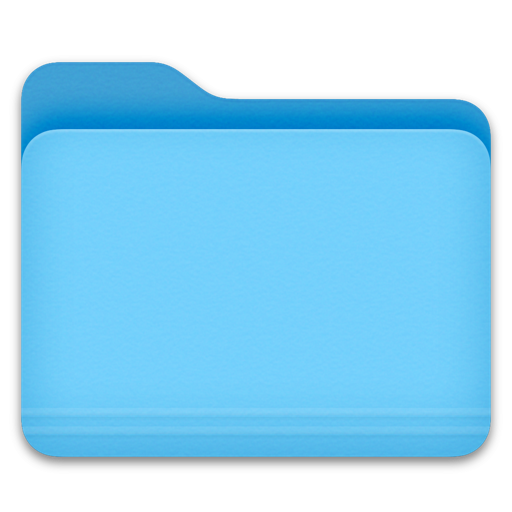

Here, the annotations are converted into csv files.

In [1]:
# Retrieve patient IDs
import os
from os.path import join

BASE_PATH = r'/data/home/webb/UNEEG_data'
parent_folders = ['20240201_UNEEG_ForMayo',
                  '20250217_UNEEG_Extended',
                  '20250501_SUBQ_SeizurePredictionCompetition_2025final'
                  ]

patients = {}

for parent_folder in parent_folders:
    parent_folder_path = join(BASE_PATH, parent_folder)
    items = os.listdir(parent_folder_path)

    for item in items:
        item_path = join(parent_folder_path, item)
        if os.path.isdir(item_path):
            patients[item] = {'path': item_path}

print(f'number of patients: {len(patients)}')
print(f'patients: {list(patients.keys())}')

number of patients: 16
patients: ['K37N36L4D', 'G39B4L9E', 'M39K4B3C', 'P73M2F6H', 'B52K3P3G', 'E85L95P2H', 'A4RW34Z5B', 'F5TW95P3X', 'L3GS57K2T', 'D63Q51K2N', 'P4Hk23M7L', 'K53T36N7F', 'E15T65H3Z', 'P2', 'P1', 'P3']


# Converting seizure annotation files into xlsx
For 20240201_UNEEG_ForMayo, each patient folder contains a .txt files with the seizure timings.
The files starts with a line with the patient id: `Patient ID: P73M2F6H`.
Each line contains a seizure. It looks like this:
`Seizure-rhythmic	2021-10-08 20:22:15.530	2021-10-08 20:22:15.530`
It contains the text 'Seizure-rhythmic', 'Seizure-rhythmic +' (no special meaning; the + can be ignored), 'Seizure-tonic', and maybe others.
Then it contains the date and time, but duplicate. Why?

For 20250217_UNEEG_Extended, it's a bit more variable.
There are multiple annotation files (all .txt). I should create a sheet just for the automatic detections and a separate one for the consensus and seizureStartEnd files.
They start with `Patienten-ID:A4RW34Z5B`.
Lines look like this sometimes: `User seizure marker	2024-12-07 11:19:37.272	2024-12-07 11:19:37.272	Seizure_Start`.
They contain `Seizure_Start` or `Seizure_End` at the end sometimes. This seems to indicate when the user marked the end / beginning of a seizure.
Some lines also start with `Seizure_Start` or `Seizure_End`.
Some files say `No Seizures`.
Patient `P4Hk23M7L` contains a marker `BUTTON DOUBLE PRESSED`

For all seizures, I want to ultimately add which edf file contains them.

## General Format
* I should assert that the first line contains the patient-ID
* Check if it contains `No Seizures`
* A line starts with `Seizure-rhythmic`, `'Seizure-rhythmic +'`, `'Seizure-tonic'`, `Seizure_Start`, `Seizure_End`, or `User seizure marker`
* It is followed by whitespace and then the duplicated date and time in the format `YYYY-MM-DD HH:MM:SS.FFF`. I should assert that the two times for a seizure are identical before saving only one.
* Sometimes, thi#s is followed by a comment like `start 5a` (indicating the visit), or `Seizure_Start`/`Seizure_End`

# Multiple annotation files
In `20250217_UNEEG_Extended`, there are multiple annotation files for each patient:
* `{patient_id}_OUTPT_SUBW_all automatic detections.txt`: contains all automatic detections
* `{patient_id}_OUTPT_SUBQ_CONSENSUS.txt`: contains single markers for seizures
* `{patient_id}_EMU_SUBQ_CONSENSUS.txt`: contains user-marked seizure starts and ends
* `{patient_id}_OUTPT_SUBQ_SeiuzreStartEnd.txt`: Contains a mix of single markers and user markers (but sometimes, there's only a seizure start with no end)

Some caveats:
* The seizures in the `EMU_SUBQ_CONSENSUS` are not (necessarily) the same as in the other files.
* Not all seizures in the `OUTPT_SUBQ_CONSENSUS` file are (necessarily) in the `SeiuzreStartEnd` file.

Procedure:
* When adding a seizure, check if it's already in the list of seizures

In [2]:
import logging
import re
import pandas as pd

# the possible ways a line can start
LINE_START_STRINGS = ('Seizure-rhythmic', 'Seizure-rhythmic +', 'Seizure-tonic', 'Seizure_Start', 'Seizure_End',
                      'BUTTON DOUBLE PRESSED',
                      'User seizure marker')


def read_line(line_idx: int, line: str):
    """Converts a line into the type, dates, and comment. Asserts that the dates are equal, and the type is valid.
    :returns: The type, datetime, and comment"""
    comment = ''
    line = line.rstrip()  # remove whitespace and new line from end of string
    # sometimes, there are multiple tabs or spaces after the seizure type. We replace this with a single tab
    line = re.sub(r'\s{2,}', r'\t', line)
    values = line.split('\t')
    if len(values) == 4:
        # it contains a comment
        comment = values.pop()
    szr_type, datetime1, datetime2 = values

    if szr_type not in LINE_START_STRINGS:
        print(f'line {line_idx}: {line}')
        print(f'{szr_type=}')
        raise ValueError(f"The following line doesn't start with {LINE_START_STRINGS}: {line}")
    if datetime1 != datetime2:
        raise ValueError(f"The dates are not the same. {datetime1=}  ,  {datetime2=}")

    return szr_type, datetime1, comment


def annotations_txt_to_dataframe(patient_annotation_files):
    for annotations_path in patient_annotation_files:
        annotations_file_name = os.path.basename(annotations_path)

        with open(annotations_path, 'r') as file:
            # read file and remove trailing white space
            content = file.read().rstrip()
            # get separate lines of file
            lines = content.split('\n')

            # assert that the file starts with the patient ID
            assert lines[0].startswith('Patient ID') or lines[0].startswith(
                'Patienten-ID'), "Annotation files doesn't start with 'Patient ID' or 'Patienten-ID'"
            lines.pop(0)  # remove the first line

            # Check if it contains no seizures
            if lines[0] == 'No Seizures':
                continue

            # go through the lines (seizures) and store them in a dataframe
            seizures = pd.DataFrame(columns=['type', 'start', 'single_marker', 'end', 'comment', 'source_file'],
                                    dtype=str)
            for i in range(len(lines)):
                szr_type, datetime, comment = read_line(i, lines[i])

                # save the start and end datetimes if this is a user-marked seizure.
                if szr_type == 'User seizure marker' and comment == 'Seizure Start':
                    seizure = {'start': datetime}

                    # Check following line (automatic detection)
                    i += 1
                    szr_type, datetime, comment = read_line(i, lines[i])
                    assert szr_type != 'User seizure marker', 'This line should be a seizure type, because the previous was a user seizure marker'
                    seizure['type'] = szr_type
                    # seizure['single_marker'] = f"'{datetime}"  # Add ' so it's interpreted as string in excel
                    seizure['single_marker'] = datetime
                    seizure['comment'] = comment

                    # Check following line (User indicated seizure end)
                    i += 1
                    szr_type, datetime, comment = read_line(i, lines[i])
                    if not (szr_type == 'User seizure marker' and comment == 'Seizure End'):
                        logging.warning(
                            'This should be the end of a user-indicated seizure, since it was indicated before.')
                    seizure['end'] = datetime
                else:
                    # The seizure just has a single marker (no start or end)
                    seizure = {'type': szr_type, 'single_marker': datetime, 'comment': comment,
                               'source_file': annotations_file_name}
                # Add seizure to dataframe
                seizures.loc[len(seizures)] = seizure

    return seizures



In [11]:
# 20240201_UNEEG_ForMayo seizure annotations
import os
from os.path import join

BASE_PATH = '/data/home/webb/all_UNEEG_data/20240201_UNEEG_ForMayo/'

# loop through all patients and generate the seizure csv
for patient in os.listdir(BASE_PATH):
    print(f'---- {patient} ----')
    patient_path = join(BASE_PATH, patient)
    annotations_path = join(patient_path, f'{patient}.txt')
    save_path = join(patient_path, f'seizure_annotations_{patient}.csv')

    seizures = annotations_txt_to_dataframe([annotations_path])
    seizures.to_csv(save_path, index=False)

---- K37N36L4D ----
---- G39B4L9E ----
---- M39K4B3C ----
---- P73M2F6H ----
---- B52K3P3G ----
---- E85L95P2H ----


In [12]:
# 20250217_UNEEG_Extended
import os
from os.path import join

BASE_PATH = '/data/home/webb/all_UNEEG_data/20250217_UNEEG_Extended/'

for patient in os.listdir(BASE_PATH):
    print(f'---- {patient} ----')
    patient_path = join(BASE_PATH, patient)

    # all automatic detections
    all_auto_det_path = join(patient_path, f'{patient}_OUTPT_SUBQ_all automatic detections.txt')
    save_path = join(patient_path, f'{patient}_OUTPT_SUBQ_all automatic detections.csv')
    all_auto_det_seizures = annotations_txt_to_dataframe([all_auto_det_path])
    all_auto_det_seizures.to_csv(save_path, index=False)

---- A4RW34Z5B ----
---- F5TW95P3X ----
---- L3GS57K2T ----
---- D63Q51K2N ----
---- P4Hk23M7L ----
---- K53T36N7F ----
---- E15T65H3Z ----
